**Course Number:** CSCA 5642 Deep Learning 

**Semester:** Summer 2, Aug 18, 2024

**Student Name:** Yuning Mu

## **1. Project Overview** {-}

**Topics and Goals**

- **Project Topic:** 

  - **Topic:** Cassava leaf disease poses a significant threat to the production of cassava, a vital carbohydrate source for millions in Africa. This project focuses on classifying cassava leaf diseases using deep learning models, aiming to identify five distinct diseases in cassava plants from leaf images, which is crucial for maintaining food security in Africa.

  - **Type of Learning:** Supervised learning.

  - **Type of Task:** Classification task (identifying the disease class).

- **Goal:** 

  - The goal of this project is to develop a model that can accurately classify cassava leaf diseases, thereby enabling farmers to take timely and appropriate measures to protect their crops from significant yield losses.

**Dataset Description**

- **Data Source:** 

  - The dataset used in this project is derived from the Cassava Leaf Disease Classification competition dataset on [Kaggle](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/), which includes labeled images of cassava leaves.

- **Description:** 

  - The dataset consists of images of cassava leaves, each labeled with one of five possible disease classes or as healthy. The dataset is crucial for developing and training deep learning models to automate disease identification.

- **Data Characteristics:** 

  - **Type:** Image data

  - **Subject Area:** Agriculture, Plant Pathology

  - **Associated Tasks:** Classification

  - **Target Value:** Disease Class (0-4, with each class corresponding to a specific disease or healthy leaves)


Importing necessary libraries:

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import optuna

In [2]:
# Load the data
train_df = pd.read_csv('./data/train.csv')

# Display basic information
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB
None


Below is the mapping of label code of each picture to the actual disease name. Code 4 indicates a healthy leaf:

In [2]:
{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
};

## 2. EDA {-}

Here we displayed the count of each disease class in the cassava leaf dataset, providing a numerical overview of how many samples belong to each class.

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64


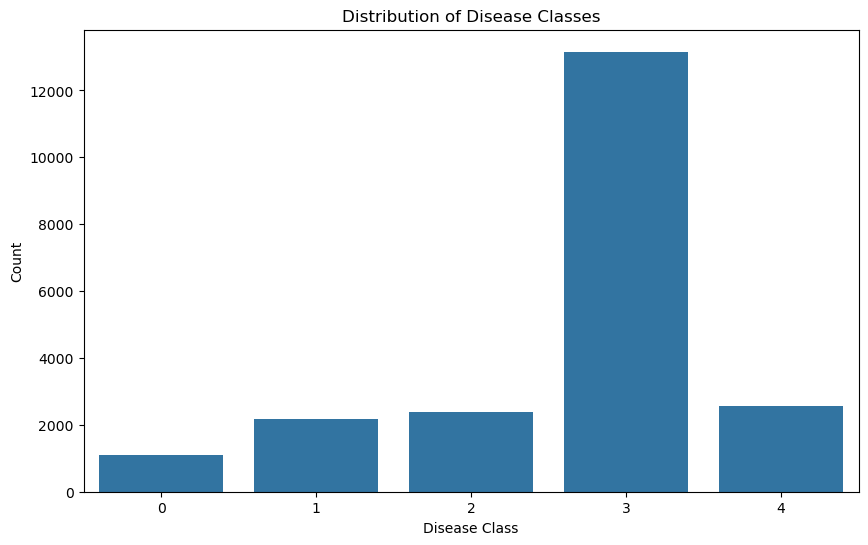

In [3]:
print(train_df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Disease Classes')
plt.xlabel('Disease Class')
plt.ylabel('Count')
plt.show()

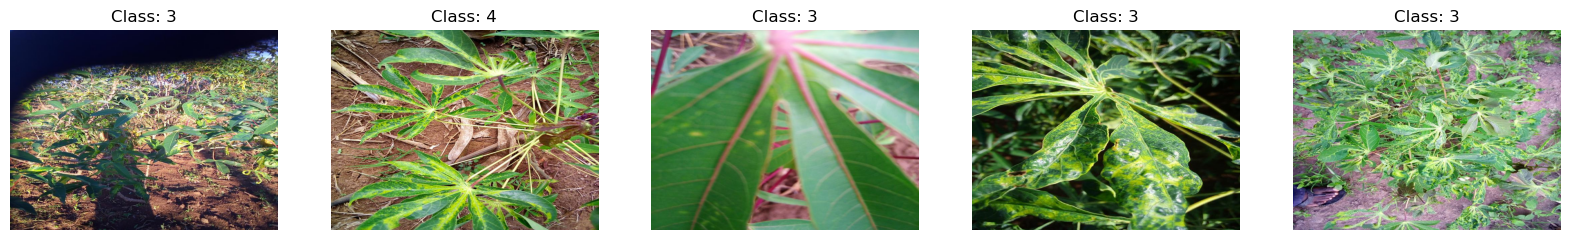

Image sizes: {(800, 600)}
Image modes: {'RGB'}


In [4]:
# Display sample images
def show_images(image_paths, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, (img_path, label) in enumerate(zip(image_paths[:num_images], labels[:num_images])):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {label}')
        axes[i].axis('off')
    plt.show()

image_dir = './data/train_images'
sample_images = [os.path.join(image_dir, img) for img in train_df['image_id'].sample(5)]
sample_labels = train_df.loc[train_df['image_id'].isin([os.path.basename(img) for img in sample_images]), 'label'].tolist()

show_images(sample_images, sample_labels)

# Analyze image properties
def get_image_stats(image_path):
    img = Image.open(image_path)
    return img.size, img.mode

image_stats = [get_image_stats(os.path.join(image_dir, img)) for img in train_df['image_id'].sample(100)]
sizes, modes = zip(*image_stats)

print(f"Image sizes: {set(sizes)}")
print(f"Image modes: {set(modes)}")

## 3. Architecture

In [5]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

# Custom Dataset
class LeafDataset(Dataset):
    def __init__(self, image_dir, dataframe=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

        if is_test:
            self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
        else:
            self.dataframe = dataframe

    def __len__(self):
        if self.is_test:
            return len(self.image_files)
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.is_test:
            img_name = self.image_files[idx]
            image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_name
        else:
            img_name = self.dataframe.iloc[idx, 0]
            image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
            label = self.dataframe.iloc[idx, 1]
            if self.transform:
                image = self.transform(image)
            return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loading
def load_data(csv_path, image_dir, batch_size=32):
    df = pd.read_csv(csv_path)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_dataset = LeafDataset(image_dir, train_df, transform=transform)
    val_dataset = LeafDataset(image_dir, val_df, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    return train_loader, val_loader

# Load data
train_loader, val_loader = load_data('./data/train.csv', './data/train_images')

Number of training samples: 17117
Number of validation samples: 4280


In [17]:
# Model Definitions
class ResNet50(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=5):
        super(EfficientNetB0, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# 4. Result and Analysis

In [21]:
# Model Selection
def get_model(model_name, num_classes=5):
    if model_name.lower() == 'resnet50':
        return ResNet50(num_classes).to(device)
    elif model_name.lower() == 'efficientnet':
        return EfficientNetB0(num_classes).to(device)
    else:
        raise ValueError("Invalid model name. Choose 'resnet50' or 'efficientnet'.")

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=2):
    best_val_acc = 0.0
    best_model = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break

    return best_val_acc

# Optuna Objective Function
def objective(trial):
    # Suggest hyperparameters
    model_name = trial.suggest_categorical("model", ["resnet50", "efficientnet"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [16, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Train and evaluate
    best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=2)
    
    return best_val_acc

In [22]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-18 18:38:24,326] A new study created in memory with name: no-name-d0180214-c0a7-4b78-85e6-a575e46636ff


Epoch 1/10, Train Loss: 1.1773, Train Acc: 61.30%, Val Loss: 0.9949, Val Acc: 65.02%
Epoch 2/10, Train Loss: 0.9404, Train Acc: 64.81%, Val Loss: 0.8751, Val Acc: 66.29%
Epoch 3/10, Train Loss: 0.8623, Train Acc: 67.44%, Val Loss: 1.0316, Val Acc: 59.42%


[I 2024-08-18 18:55:43,061] Trial 0 finished with value: 66.28504672897196 and parameters: {'model': 'efficientnet', 'lr': 0.029713090564098908, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 0 with value: 66.28504672897196.


Epoch 4/10, Train Loss: 0.7919, Train Acc: 70.43%, Val Loss: 1.0945, Val Acc: 60.02%
Early stopping triggered after epoch 4
Epoch 1/10, Train Loss: 1.2768, Train Acc: 60.11%, Val Loss: 1.1630, Val Acc: 62.48%
Epoch 2/10, Train Loss: 1.0834, Train Acc: 61.70%, Val Loss: 1.0204, Val Acc: 64.28%
Epoch 3/10, Train Loss: 0.9571, Train Acc: 64.49%, Val Loss: 1.0159, Val Acc: 65.70%
Epoch 4/10, Train Loss: 0.8966, Train Acc: 65.93%, Val Loss: 0.9383, Val Acc: 63.67%
Epoch 5/10, Train Loss: 0.8496, Train Acc: 67.21%, Val Loss: 0.8480, Val Acc: 66.38%
Epoch 6/10, Train Loss: 0.8094, Train Acc: 68.80%, Val Loss: 0.9708, Val Acc: 61.45%


[I 2024-08-18 19:36:49,099] Trial 1 finished with value: 66.3785046728972 and parameters: {'model': 'resnet50', 'lr': 0.018881828258453207, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 1 with value: 66.3785046728972.


Epoch 7/10, Train Loss: 0.7779, Train Acc: 70.34%, Val Loss: 1.0055, Val Acc: 62.10%
Early stopping triggered after epoch 7
Epoch 1/10, Train Loss: 0.6144, Train Acc: 77.89%, Val Loss: 0.4738, Val Acc: 82.94%
Epoch 2/10, Train Loss: 0.4292, Train Acc: 85.10%, Val Loss: 0.4647, Val Acc: 84.07%
Epoch 3/10, Train Loss: 0.3476, Train Acc: 87.50%, Val Loss: 0.4983, Val Acc: 83.69%


[I 2024-08-18 20:51:54,853] Trial 2 finished with value: 84.06542056074767 and parameters: {'model': 'efficientnet', 'lr': 0.0935982070759799, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 2 with value: 84.06542056074767.


Epoch 4/10, Train Loss: 0.2766, Train Acc: 90.03%, Val Loss: 0.5350, Val Acc: 83.34%
Early stopping triggered after epoch 4
Epoch 1/10, Train Loss: 0.8270, Train Acc: 69.53%, Val Loss: 0.6265, Val Acc: 78.62%
Epoch 2/10, Train Loss: 0.6143, Train Acc: 78.13%, Val Loss: 0.6887, Val Acc: 75.96%
Epoch 3/10, Train Loss: 0.5597, Train Acc: 80.04%, Val Loss: 0.5461, Val Acc: 80.30%
Epoch 4/10, Train Loss: 0.5331, Train Acc: 81.30%, Val Loss: 0.6118, Val Acc: 78.81%
Epoch 5/10, Train Loss: 0.5009, Train Acc: 82.26%, Val Loss: 0.5465, Val Acc: 81.07%
Epoch 6/10, Train Loss: 0.4843, Train Acc: 82.61%, Val Loss: 0.5283, Val Acc: 81.80%
Epoch 7/10, Train Loss: 0.4616, Train Acc: 83.59%, Val Loss: 0.5133, Val Acc: 81.68%


[I 2024-08-18 21:26:33,318] Trial 3 finished with value: 81.79906542056075 and parameters: {'model': 'efficientnet', 'lr': 0.00501833458523034, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 2 with value: 84.06542056074767.


Epoch 8/10, Train Loss: 0.4401, Train Acc: 84.54%, Val Loss: 0.5375, Val Acc: 80.65%
Early stopping triggered after epoch 8
Epoch 1/10, Train Loss: 0.7949, Train Acc: 70.43%, Val Loss: 0.5932, Val Acc: 78.86%
Epoch 2/10, Train Loss: 0.5103, Train Acc: 81.51%, Val Loss: 0.4998, Val Acc: 82.59%
Epoch 3/10, Train Loss: 0.3805, Train Acc: 86.59%, Val Loss: 0.4741, Val Acc: 83.69%
Epoch 4/10, Train Loss: 0.2761, Train Acc: 90.51%, Val Loss: 0.5337, Val Acc: 82.99%
Epoch 5/10, Train Loss: 0.1863, Train Acc: 93.89%, Val Loss: 0.5311, Val Acc: 83.81%
Epoch 6/10, Train Loss: 0.1159, Train Acc: 96.41%, Val Loss: 0.5856, Val Acc: 84.18%
Epoch 7/10, Train Loss: 0.0645, Train Acc: 98.23%, Val Loss: 0.6279, Val Acc: 83.86%


[I 2024-08-18 22:14:04,740] Trial 4 finished with value: 84.1822429906542 and parameters: {'model': 'resnet50', 'lr': 0.011438817156730448, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 4 with value: 84.1822429906542.


Epoch 8/10, Train Loss: 0.0430, Train Acc: 99.00%, Val Loss: 0.7086, Val Acc: 83.13%
Early stopping triggered after epoch 8
Epoch 1/10, Train Loss: 0.6380, Train Acc: 77.30%, Val Loss: 0.4768, Val Acc: 83.76%
Epoch 2/10, Train Loss: 0.4402, Train Acc: 84.27%, Val Loss: 0.4492, Val Acc: 84.77%
Epoch 3/10, Train Loss: 0.3517, Train Acc: 87.46%, Val Loss: 0.4775, Val Acc: 83.81%


[I 2024-08-18 22:31:12,892] Trial 5 finished with value: 84.76635514018692 and parameters: {'model': 'efficientnet', 'lr': 0.05342276092276966, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 5 with value: 84.76635514018692.


Epoch 4/10, Train Loss: 0.2796, Train Acc: 89.82%, Val Loss: 0.4963, Val Acc: 84.49%
Early stopping triggered after epoch 4
Epoch 1/10, Train Loss: 0.6143, Train Acc: 77.96%, Val Loss: 0.4711, Val Acc: 83.60%
Epoch 2/10, Train Loss: 0.4302, Train Acc: 84.68%, Val Loss: 0.4478, Val Acc: 84.51%
Epoch 3/10, Train Loss: 0.3363, Train Acc: 88.08%, Val Loss: 0.4646, Val Acc: 83.36%
Epoch 4/10, Train Loss: 0.2680, Train Acc: 90.22%, Val Loss: 0.5151, Val Acc: 85.28%
Epoch 5/10, Train Loss: 0.2146, Train Acc: 92.29%, Val Loss: 0.5644, Val Acc: 83.88%


[I 2024-08-18 22:57:04,472] Trial 6 finished with value: 85.2803738317757 and parameters: {'model': 'efficientnet', 'lr': 0.07849653799366987, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 6 with value: 85.2803738317757.


Epoch 6/10, Train Loss: 0.1613, Train Acc: 94.49%, Val Loss: 0.6203, Val Acc: 82.99%
Early stopping triggered after epoch 6
Epoch 1/10, Train Loss: 1.1808, Train Acc: 61.11%, Val Loss: 1.2135, Val Acc: 62.36%
Epoch 2/10, Train Loss: 0.9737, Train Acc: 63.78%, Val Loss: 0.9713, Val Acc: 68.18%
Epoch 3/10, Train Loss: 0.9041, Train Acc: 65.94%, Val Loss: 1.4012, Val Acc: 39.37%
Epoch 4/10, Train Loss: 0.8446, Train Acc: 68.08%, Val Loss: 0.9301, Val Acc: 70.54%
Epoch 5/10, Train Loss: 0.8059, Train Acc: 69.95%, Val Loss: 0.7996, Val Acc: 69.84%


[I 2024-08-18 23:22:52,193] Trial 7 finished with value: 70.53738317757009 and parameters: {'model': 'efficientnet', 'lr': 0.0444135547078936, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 6 with value: 85.2803738317757.


Epoch 6/10, Train Loss: 0.8134, Train Acc: 69.98%, Val Loss: 1.0929, Val Acc: 63.86%
Early stopping triggered after epoch 6
Epoch 1/10, Train Loss: 1.3620, Train Acc: 60.59%, Val Loss: 1.5210, Val Acc: 62.48%
Epoch 2/10, Train Loss: 1.0687, Train Acc: 61.78%, Val Loss: 1.0315, Val Acc: 62.59%
Epoch 3/10, Train Loss: 0.9686, Train Acc: 63.77%, Val Loss: 0.9282, Val Acc: 65.98%
Epoch 4/10, Train Loss: 0.9357, Train Acc: 64.81%, Val Loss: 0.9692, Val Acc: 64.09%


[I 2024-08-18 23:52:24,082] Trial 8 finished with value: 65.98130841121495 and parameters: {'model': 'resnet50', 'lr': 0.0339847602308825, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 6 with value: 85.2803738317757.


Epoch 5/10, Train Loss: 0.8932, Train Acc: 65.87%, Val Loss: 0.9857, Val Acc: 63.88%
Early stopping triggered after epoch 5
Epoch 1/10, Train Loss: 0.6115, Train Acc: 78.07%, Val Loss: 0.4740, Val Acc: 83.34%
Epoch 2/10, Train Loss: 0.3816, Train Acc: 86.87%, Val Loss: 0.4378, Val Acc: 84.86%
Epoch 3/10, Train Loss: 0.2475, Train Acc: 91.24%, Val Loss: 0.4869, Val Acc: 83.74%


[I 2024-08-19 00:15:35,618] Trial 9 finished with value: 84.85981308411215 and parameters: {'model': 'resnet50', 'lr': 0.05099347059468389, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 6 with value: 85.2803738317757.


Epoch 4/10, Train Loss: 0.1478, Train Acc: 94.84%, Val Loss: 0.5723, Val Acc: 83.15%
Early stopping triggered after epoch 4
Best trial:
  Value:  85.2803738317757
  Params: 
    model: efficientnet
    lr: 0.07849653799366987
    batch_size: 16
    optimizer: SGD


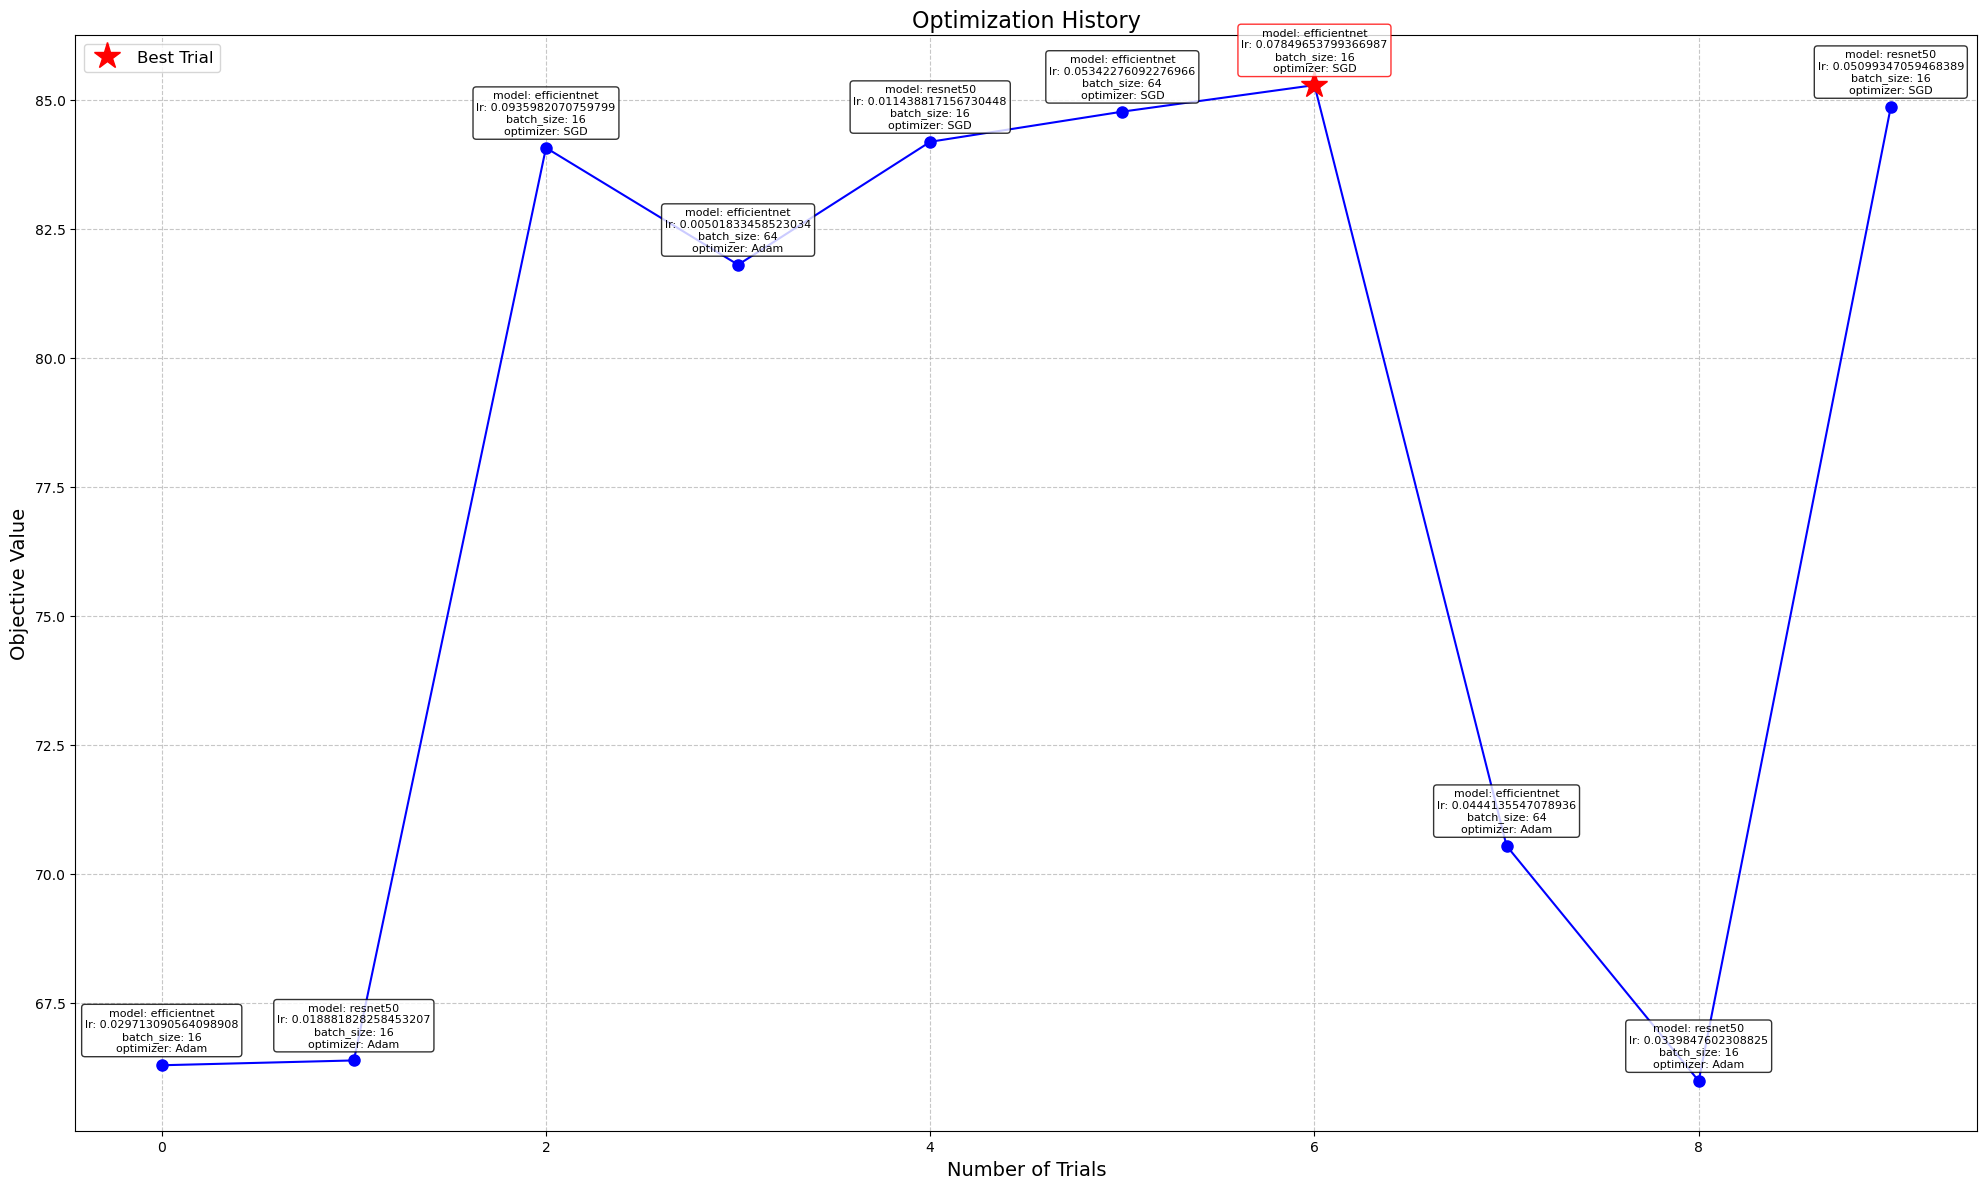

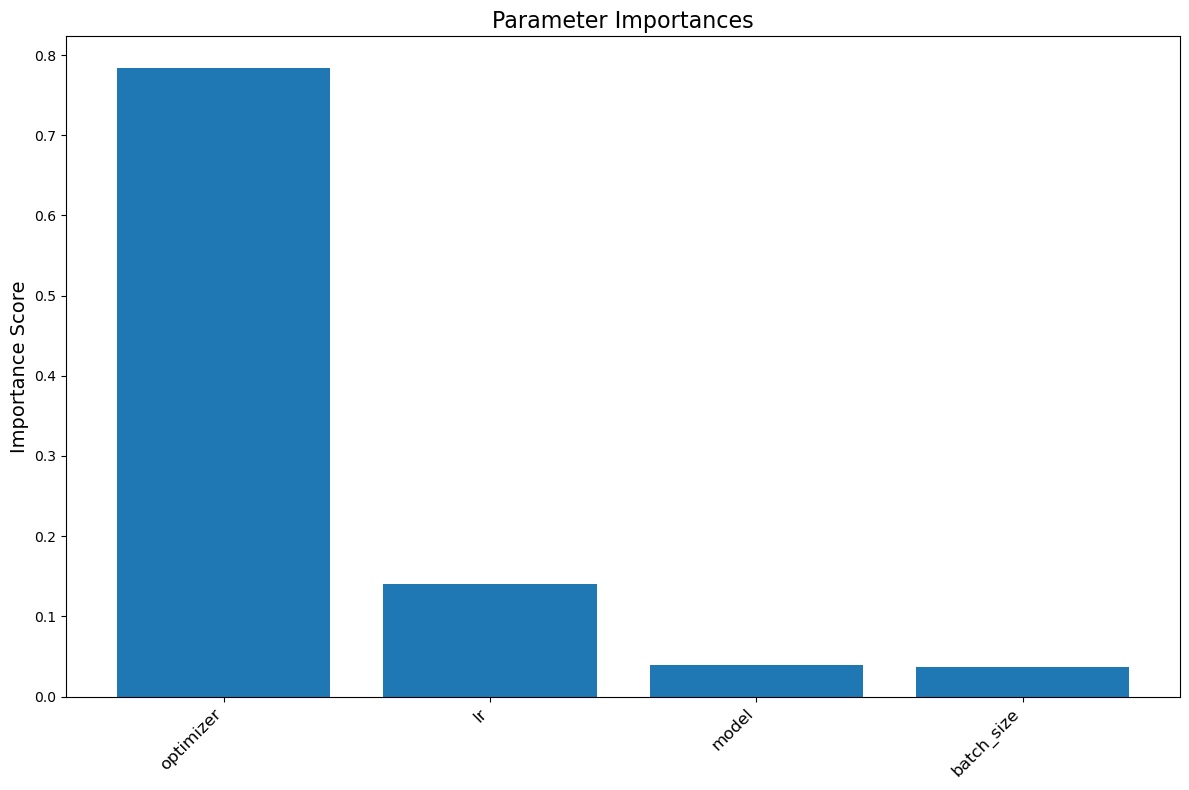

Visualization results displayed inline


In [56]:
def visualize_optuna_results(study):
    # Plot optimization history with hyperparameter annotations
    plt.figure(figsize=(20, 12))
    plt.title("Optimization History", fontsize=16)
    plt.xlabel("Number of Trials", fontsize=14)
    plt.ylabel("Objective Value", fontsize=14)

    trials = study.trials
    values = [t.value for t in trials]
    best_trial = study.best_trial
    
    # Plot all trials
    plt.plot(range(len(trials)), values, 'bo-', markersize=8)
    
    # Highlight the best trial
    plt.plot(best_trial.number, best_trial.value, 'r*', markersize=20, label='Best Trial')

    # Annotate all points with hyperparameter values
    for i, trial in enumerate(trials):
        annotation = "\n".join([f"{k}: {v}" for k, v in trial.params.items()])
        color = 'red' if trial.number == best_trial.number else 'black'
        plt.annotate(annotation, (i, values[i]), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=8, 
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.8))

    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

    # Plot parameter importances
    plt.figure(figsize=(12, 8))
    plt.title("Parameter Importances", fontsize=16)
    importances = optuna.importance.get_param_importances(study)
    params, scores = zip(*importances.items())
    plt.bar(params, scores)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.ylabel("Importance Score", fontsize=14)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()

    print("Visualization results displayed inline")

visualize_optuna_results(study)

In [59]:
# Train final model with best parameters
def train_final_model(best_params, train_loader, val_loader):
    model = get_model(best_params['model'])
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])

    best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
    print(f"Final model best validation accuracy: {best_val_acc:.2f}%")

    # Save the model
    torch.save(model.state_dict(), './model/cassava_leaf_disease_model.pth')
    
    return model

final_model = train_final_model(study.best_trial.params, train_loader, val_loader)
final_model

Epoch 1/10, Train Loss: 0.6201, Train Acc: 77.44%, Val Loss: 0.5061, Val Acc: 82.27%
Epoch 2/10, Train Loss: 0.4338, Train Acc: 84.47%, Val Loss: 0.4402, Val Acc: 85.23%
Epoch 3/10, Train Loss: 0.3400, Train Acc: 87.78%, Val Loss: 0.4845, Val Acc: 84.00%
Epoch 4/10, Train Loss: 0.2675, Train Acc: 90.21%, Val Loss: 0.5373, Val Acc: 83.29%
Early stopping triggered after epoch 4
Final model best validation accuracy: 85.23%


EfficientNetB0(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

## 6. Submission

In [60]:
def predict_test_set(model, test_loader):
    model.eval()
    predictions = []
    image_files = []
    with torch.no_grad():
        for inputs, img_names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            image_files.extend(img_names)
    return predictions, image_files

In [72]:
test_dataset = LeafDataset('./data/test_images', transform=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=study.best_trial.params['batch_size'], shuffle=False, num_workers=0)

test_predictions, test_image_files = predict_test_set(final_model, test_loader)

# Save predictions
test_df = pd.DataFrame({
    'image_id': test_image_files,
    'label': test_predictions
})
test_df.to_csv('./output/test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")

Test predictions saved to 'test_predictions.csv'
